In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!pip install --force-reinstall -v openai==1.55.3

In [2]:
%cd '/content/drive/MyDrive'
%cd 'LLM PROJECT'
%ls

/content/drive/MyDrive
/content/drive/MyDrive/LLM PROJECT
coco_images/  config.json  eval.ipynb  llamallava_stage2_epoch1.pt  vicuna_llava.py


drive/  sample_data/


In [ ]:
import base64
import os
from openai import OpenAI
import json


api_key = ""
client = OpenAI(api_key=api_key)

In [ ]:
"""
Get evaluate Skyview using GPT
"""

def encode_image(folder, image_filename):
    image_path = os.path.join("Aerial_Landscapes", folder, image_filename)
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')



system_message = {
    "role": "system",
    "content": [
        {
        "type": "text",
        "text": """You are a helpful vision assistant that is going to help me understand the terrains of landscape images. The user wants to understand whether there is a place in the image that someone could land a small airplane. So being descriptive with the image given this context is crucial.
            If there is no possible emergency landing areas then this is also something to consider. Keep your output to 5 sentences, with the last sentence giving a score on feasibility of landing an airplane. Specifically, the first four sentences will describe the landscape and the pros and cons of it given this emergency landing scenario.
            The last sentence you should give a score out of 100 for whether the plane can land somewhere in the image or not, and the chance of survival if landed. 0 would indicate there is no survival chances, such as in mountainous areas or deep oceans and 100 would indicate an airport which is really safe to land on.
            Note: a small airplane is 26 feet long with a wingspan of 36 feet and a cabin height of roughly 4 feet. Here is an example response:
            1) The landscape shows a winding river surrounded by uneven terrain, with visible vegetation and some open areas.
            2) The riverbanks appear to have patches of flat land, but the irregularity and potential wetness of the soil pose risks.
            3) Vegetation is scattered, which could obstruct a small plane's landing, and the lack of a consistent open stretch limits options for a safe touchdown.
            4) While the river itself is unsuitable for landing, the narrow flat stretches near it may offer limited possibilities in an extreme emergency, though precision is critical.
            Score: 35/100 - The terrain presents significant challenges for landing, with survival chances depending on precision and the condition of the nearby flat areas."""
        }
    ]
}

for datum in skyview_data:
    base64_image = encode_image(datum["folder"], datum["image"])

    user_content = [
        {
            "type": "image_url",
            "image_url": {
                "url": f"data:image/jpeg;base64,{base64_image}"
            }
        }
    ]

    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            system_message,
            {
                "role": "user",
                "content": user_content
            }
        ],
    )

    answer = response.choices[0].message.content

    datum["gpt"] = answer

with open("skyview_data_gpt.json", "w") as outfile:
    json.dump(skyview_data, outfile, indent=2)

# #TEST
# for d in skyview_data[:5]:
#     print(f"ID: {d['id']}, Folder: {d['folder']}, Image: {d['image']}")
#     print("GPT Analysis:", d["gpt"])
#     print("---")


KeyboardInterrupt: 

In [8]:
import sys
print(sys.path)
sys.path.append('/content/drive/MyDrive/LLM PROJECT')


['/content', '/env/python', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/usr/local/lib/python3.10/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.10/dist-packages/IPython/extensions', '/usr/local/lib/python3.10/dist-packages/setuptools/_vendor', '/root/.ipython']


In [ ]:
from huggingface_hub import login
login(token="")

In [ ]:
import torch
from transformers import AutoConfig
from vicuna_llava import llava
from accelerate import Accelerator

accelerator = Accelerator()
# Get LLAVA Model
config_path = "../config.json" 
config = AutoConfig.from_pretrained(config_path)
llava_model = llava(config, llmURL="meta-llama/Llama-3.2-1B", accelerator=accelerator)
llava_model = accelerator.prepare(llava_model)




config.json:   0%|          | 0.00/843 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/185 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.52k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/50.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/301 [00:00<?, ?B/s]

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


In [ ]:
# Set Weights for LLAVA from training
weights_path = "llamallava_stage2_epoch1.pt"
llava_model.load_state_dict(torch.load(weights_path, map_location="cpu"), strict=False)

llava_model.to("cuda" if torch.cuda.is_available() else "cpu")
print("Model weights loaded successfully!")

<ipython-input-6-304a9030d775>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  llava_model.load_state_dict(torch.load(weights_path, map_location="cpu"), strict=False)


Model weights loaded successfully!


In [ ]:
import json

# Get data from the json
data = []
with open("skyview_data_gpt.json", "r") as infile:
    data = json.load(infile)


new_system_message = {
    "role": "system",
    "content": [
        {
        "type": "text",
        "text": """ You are going to help me judge between the following output for which is more descriptive given the following image.
         Specifically, I want you to tell me which description more accurately describes the landscape. Additionally, each response will give score which determines how suitable this landscape would be an emergency landing for a small airplane.
         Note: a small airplane is 26 feet long with a wingspan of 36 feet and a cabin height of roughly 4 feet.
         With this score, a lower score would mean that this landscape is very dangerous for a emergency landing, and a high score would deem the landscape in the image to be super safe. An example of a super safe landscape is an airport and an example of a dangerous landscape is the deep ocean.
         I want you to consider this score when deciding which response was the best.
         Your input will be in the form of
        ---
         Resopnse1: {RESPONSE1}
         Response2: {RESPONSE2}
         {Image}
        ---
         Lastly, I want you to give your response in a certain format. This format will be in a json structure. Here is an exmample.
         {
            Response: # 1 or 2 depending on which response was better
            ResponseDetail: # Put the full response here that you deemed better
            Score: 79/100 # Score of the response that you said was better
            Description: # Explain why this response was better than the other here

        }"""
        }

    ]
}
scores = {} # STORE SCORES LIKE GPT-> [(id,score)] LLAVA > [(id,score)]

for datum in data:
    base64_image = encode_image(datum["folder"], datum["image"])

    # CALL LLAVA HERE
    llava_res = ""



    user_content = [

        {
            "type": "text",
            "text": f"""
            RESPONSE 1: {llava_res}
            RESPONSE 2: {data['gpt']}"""

        },
        {
            "type": "image_url",
            "image_url": {
                "url": f"data:image/jpeg;base64,{base64_image}"
            }
        }
    ]

    # Make the API call
    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            new_system_message,
            {
                "role": "user",
                "content": user_content
            }
        ],
    )

    #PARSE RESPONSE, MAKE SURE GPT RESPONDS IN A WAY THAT IS EASIER TO RESPOND
    gpt_score = 0
    llava_score = 0

    scores['gpt'].append((data['id'], gpt_score))
    scores['llava'].append((data['id'], llava_score))




with open("skyview_eval_scores.json", "w") as outfile:
    json.dump(scores, outfile, indent=2)

NameError: name 'json' is not defined

In [ ]:
"""
Evaluate on LLaVA Bench
"""

from PIL import Image
import matplotlib.pyplot as plt
llava_bench_system_message = {
    "role": "system",
    "content": [
        {
        "type": "text",
        "text": """
        You are going to help me judge between the following outputs to determine which is more descriptive given the provided image.
        Your input will be in the following form:
        ---
        Response1: {RESPONSE1}
        Response2: {RESPONSE2}
        Image: {IMAGE}
        ---

        You will evaluate both responses based on these criteria:
        1. **Descriptiveness**: How well the response captures the details and essence of the image.
        2. **Clarity**: How clearly and understandably the response communicates the information.
        3. **Accuracy**: How factually accurate the response is based on the provided image.
        4. **Level of Detail**: How thorough and complete the response is in explaining the image.

        For each criterion, assign a score between 1 and 10 for each response. Then calculate an **overall score** for each response by averaging the scores across all dimensions.

        Finally, provide your judgment in this exact JSON format:
        {
            "Response_num": 1 or 2 # The response number that you judge to be better
            "Response1": "{RESPONSE1}",  # The full response 1
            "Response2": "{RESPONSE2}", # The full response 2
            "Scores": {
                "Response1": {
                    "Descriptiveness": X,  # Score for Response 1 on Descriptiveness (1-10)
                    "Clarity": X,          # Score for Response 1 on Clarity (1-10)
                    "Accuracy": X,         # Score for Response 1 on Accuracy (1-10)
                    "LevelOfDetail": X,    # Score for Response 1 on Level of Detail (1-10)
                    "Overall": X           # Average score for Response 1
                },
                "Response2": {
                    "Descriptiveness": X,  # Score for Response 2 on Descriptiveness (1-10)
                    "Clarity": X,          # Score for Response 2 on Clarity (1-10)
                    "Accuracy": X,         # Score for Response 2 on Accuracy (1-10)
                    "LevelOfDetail": X,    # Score for Response 2 on Level of Detail (1-10)
                    "Overall": X           # Average score for Response 2
                }
            },
            "Description": "Explain why the chosen response (1 or 2) is better in 1-2 sentences, considering the criteria above."
        }
        """
        }

    ]

}

def encode_image_bench(image_filename):
    image_path = os.path.join("coco_images", image_filename)
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')


In [8]:
import json
# Get data from the json
data = []
with open("coco_images/coco204_val_gpt4_qa_30x2.jsonl", "r") as file:
    data = [json.loads(line) for line in file]

Xtra: The picture shows a young boy playing a video game on a laptop. The boy is seated on a chair with his legs extended, and he is holding a controller in his hands. The laptop is placed on a table beside him, and the game is displayed on the screen. The boy is looking at the screen and is engaged in the game. The image is taken from a perspective that shows the boy's face and the laptop, with the game screen in the background. The boy is shown in a positive and enthusiastic mood, and he is enjoying the game. The image is well-lit and has a clear and clear focus on the boy and the laptop. The image is also well-posed and well-structured, with the boy's face and the laptop in the center of the image, and the game screen in the background. The image is also well-composed and well-arranged, with the boy's face and the laptop in the center of the image, and the Can you elaborate on the elements of the picture provided?


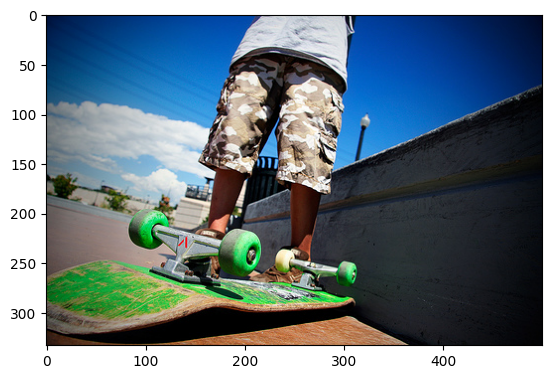

In [ ]:
datum = data[1]
instruction = datum["instruction"]
image = Image.open("coco_images/" + datum['image'])
llava_res = llava_model.generate(image=image, prompt=instruction, max_new_tokens=200)
print(llava_res, instruction)
plt.imshow(image)

In [ ]:
print(llava_res)

-skateboard.png<|end_of_text|>


In [ ]:
import os
import base64
from openai import OpenAI
api_key = ""
client = OpenAI(api_key=api_key)
bench_scores = {}
ind = 0

"""
Use GPT to judge responses
"""

for datum in data:
    base64_image = encode_image_bench(datum["image"])
    instruction = datum["instruction"]
    # CALL LLAVA HERE
    image = Image.open("coco_images/" + datum['image'])
    llava_res = llava_model.generate(image=image, prompt=instruction, max_new_tokens=50)
    user_content = [

        {
            "type": "text",
            "text": f"""
            RESPONSE 1: {llava_res}
            RESPONSE 2: {datum['output']}"""

        },
        {
            "type": "image_url",
            "image_url": {
                "url": f"data:image/jpeg;base64,{base64_image}"
            }
        }
    ]

    # Make the API call
    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            llava_bench_system_message,
            {
                "role": "user",
                "content": user_content
            }
        ],
    )

    res = response.choices[0].message.content

    print(res)


    bench_scores[ind] = res
    ind += 1

with open('llava_bench_final.json', "w") as outfile:
    json.dump(bench_scores, outfile, indent=2)



/content/drive/MyDrive/LLM PROJECT/vicuna_llava.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


{
    "Response_num": 2,
    "Response1": "-skateboard.png",
    "Response2": "The skateboard in the image is in an upside-down position, with its wheels pointing up and laying on the ground.",
    "Scores": {
        "Response1": {
            "Descriptiveness": 1,
            "Clarity": 1,
            "Accuracy": 1,
            "LevelOfDetail": 1,
            "Overall": 1
        },
        "Response2": {
            "Descriptiveness": 7,
            "Clarity": 8,
            "Accuracy": 7,
            "LevelOfDetail": 6,
            "Overall": 7
        }
    },
    "Description": "Response 2 is better because it provides a clear and detailed description of the skateboard's position and orientation, while Response 1 lacks meaningful content."
}
```json
{
    "Response_num": 2,
    "Response1": "Xtra: The picture shows a young boy playing a video game on a laptop. The boy is seated on a chair with his legs extended, and he is holding a controller in his hands. The laptop is placed on

In [ ]:
# Process GPT response into proper dict format
for i in bench_scores:
    if not isinstance(bench_scores[i], dict):  # Process non-dict entries
        j = 0
        z = len(bench_scores[i]) - 1

        # Adjust start and end indices
        while j < len(bench_scores[i]) and bench_scores[i][j] != '{':
            j += 1
        while z > j and bench_scores[i][z] != '}':
            z -= 1

        json_string = bench_scores[i][j:z + 1].strip()
        # print(f"Extracted JSON string for key {i}: {json_string}")  # Debug

        try:
            bench_scores[i] = json.loads(json_string)
        except json.JSONDecodeError as e:
            print(f"Failed to parse JSON for key {i}: {e}")
        except Exception as e:
            print(f"Unexpected error for key {i}: {e}")




In [ ]:
# Turn scores into relative scores
new_scores = []
for i in range(90):
  f = bench_scores[i]['Scores']['Response1']['Overall']
  f = min(f, bench_scores[i]['Scores']['Response2']['Overall'])
  rel = f / bench_scores[i]['Scores']['Response2']['Overall']
  new_scores.append(rel)


In [57]:
print(new_scores)

[0.14285714285714285, 0.15625, 0.42857142857142855, 0.6666666666666666, 0.45714285714285713, 0.1111111111111111, 0.375, 0.37142857142857144, 0.1111111111111111, 0.11764705882352941, 0.3333333333333333, 0.4, 0.41935483870967744, 0.13513513513513514, 0.2222222222222222, 0.16, 0.37142857142857144, 0.4857142857142857, 0.5625, 0.4722222222222222, 0.37142857142857144, 0.6923076923076923, 0.11428571428571428, 0.5555555555555556, 0.16, 0.5714285714285714, 0.45714285714285713, 0.12121212121212122, 0.4117647058823529, 0.6451612903225806, 0.12903225806451613, 0.5882352941176471, 0.12903225806451613, 0.16666666666666666, 0.2777777777777778, 0.5294117647058824, 0.7, 0.36363636363636365, 0.40625, 0.1875, 0.3939393939393939, 0.4444444444444444, 0.4838709677419355, 0.2222222222222222, 0.10810810810810811, 0.125, 0.10810810810810811, 0.3783783783783784, 1.0, 0.2222222222222222, 0.65625, 0.5909090909090909, 0.3142857142857143, 0.5714285714285714, 0.13793103448275862, 0.53125, 0.11428571428571428, 0.16, 

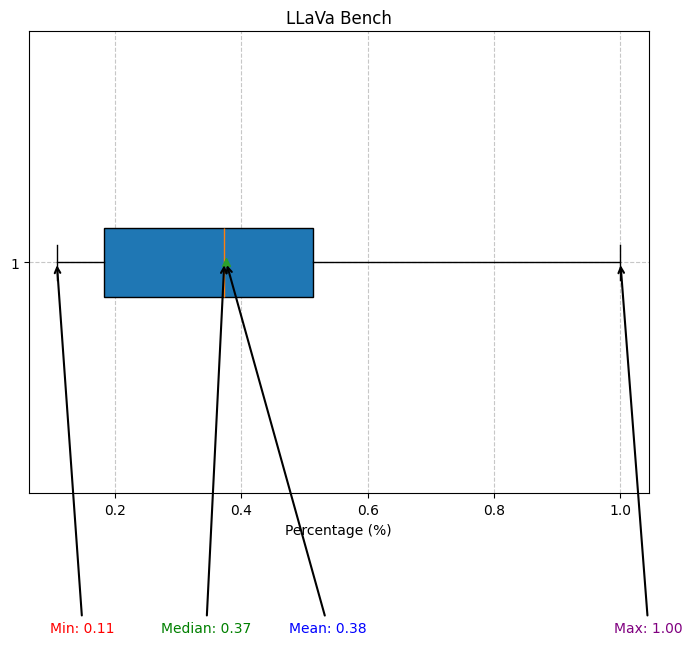

In [ ]:
import numpy as np
"""
Create Plot with Results
"""
mean_value = np.mean(new_scores)
median_value = np.median(new_scores)
std_value = np.std(new_scores)
min_value = np.min(new_scores)
max_value = np.max(new_scores)

# Plot the boxplot
plt.figure(figsize=(8, 6))
box = plt.boxplot(new_scores, vert=False, patch_artist=True, showmeans=True)

# Annotate mean
plt.annotate(f'Mean: {mean_value:.2f}', xy=(mean_value, 1), xytext=(mean_value + 0.1, 0.2),
             arrowprops=dict(facecolor='blue', arrowstyle='->', lw=1.5), fontsize=10, color='blue')

# Annotate median
plt.annotate(f'Median: {median_value:.2f}', xy=(median_value, 1), xytext=(median_value - 0.1, 0.2),
             arrowprops=dict(facecolor='green', arrowstyle='->', lw=1.5), fontsize=10, color='green')

# Annotate min
plt.annotate(f'Min: {min_value:.2f}', xy=(min_value, 1), xytext=(min_value - 0.01, 0.2),
             arrowprops=dict(facecolor='red', arrowstyle='->', lw=1.5), fontsize=10, color='red')

# Annotate max
plt.annotate(f'Max: {max_value:.2f}', xy=(max_value, 1), xytext=(max_value - 0.01, 0.2),
             arrowprops=dict(facecolor='purple', arrowstyle='->', lw=1.5), fontsize=10, color='purple')

# Title and labels
plt.title('LLaVa Bench')
plt.xlabel('Percentage (%)')
plt.grid(linestyle='--', alpha=0.7)
plt.show()
